# Profiling RGPD - Stages (2023-2025)

Objectif: comprendre la structure du CSV, mesurer la qualite, et identifier les risques RGPD avant toute transformation.

Pourquoi c'est important:
- On ne nettoie pas une donnee qu'on ne comprend pas.
- Le profiling revele les colonnes sensibles (PII), les valeurs manquantes, et les incoherences.
- On prend des decisions de nettoyage et d'anonymisation sur des faits, pas des suppositions.


In [1]:
import pandas as pd
from scripts.config import RAW_PATH, PII_COLUMNS


In [2]:
# Charger le CSV brut (separateur ';', encodage latin1)
df = pd.read_csv(RAW_PATH, sep=';', encoding='latin1')
df.shape


(3820, 11)

In [3]:
# Types et colonnes
df.dtypes


Programme           object
Promotion           object
Sujet               object
Domaine de stage    object
Société             object
Adresse société     object
Code postal         object
Ville               object
Pays                object
Nom étudiant        object
email étudiant      object
dtype: object

In [4]:
# Pourcentage de valeurs manquantes
missing_pct = (df.isna().mean() * 100).round(2)
missing_pct.sort_values(ascending=False)


Domaine de stage    27.91
Code postal          0.13
Société              0.05
Adresse société      0.05
Ville                0.05
Pays                 0.05
email étudiant       0.05
Programme            0.00
Promotion            0.00
Sujet                0.00
Nom étudiant         0.00
dtype: float64

In [5]:
# PII detectees selon la liste connue
pii_found = [c for c in df.columns if c in PII_COLUMNS]
pii_found


['Nom étudiant', 'email étudiant']

In [6]:
# Apercu sans PII (privacy first)
non_pii_cols = [c for c in df.columns if c not in PII_COLUMNS]
df[non_pii_cols].head(3)


,Programme,Promotion,Sujet,Domaine de stage,Société,Adresse société,Code postal,Ville,Pays
0,PREPA1,2023-2024,stage d´exécution L1,EXECUTION,Fondation de Coubertin,"Dom. de Coubertin, 78470 Saint-Rémy-lès-Chevreuse",78470,Saint-Rémy-lès-Chevreuse,FR
1,PREPA1,2023-2024,stage d´exécution L1,EXECUTION,SARL AMS SERVICES,Bâtiment G3 Place de Bel État Bat G,78280,Guyancourt,FR
2,PREPA1,2023-2024,stage d´exécution L1,EXECUTION,Cityz Media,24 Quai Alphonse Le Gallo,92100,Boulogne-Billancourt,FR


## Verification DuckDB

Cette section confirme que la table a bien ete chargee dans DuckDB.


In [7]:
import duckdb
from scripts.config import DUCKDB_PATH

con = duckdb.connect(str(DUCKDB_PATH), read_only=True)
con.execute("SELECT COUNT(*) AS nb_lignes FROM stages_clean").df()


,nb_lignes
0,3820


## Visualisations analytiques (DuckDB)

Graphiques agreges et privacy-safe pour un etudiant (tendances, zones, domaines)
et un recruteur (entreprises recurrents, marche global).


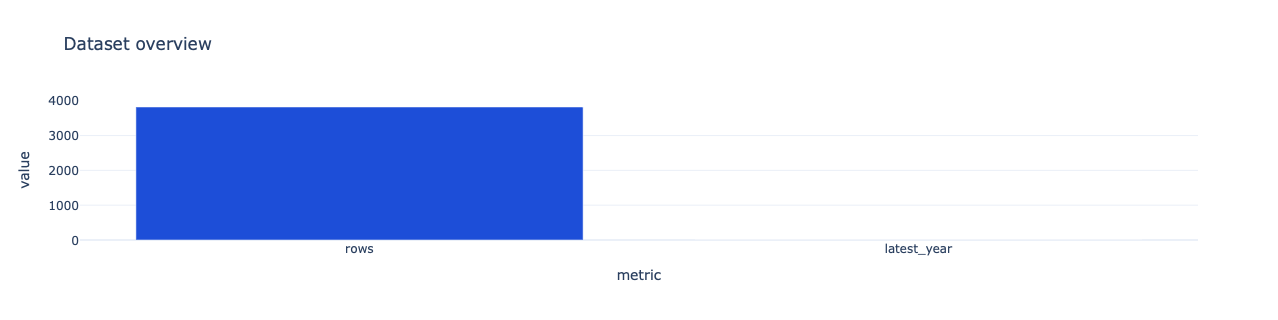

In [8]:
import duckdb
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
from scripts.config import DUCKDB_PATH

px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = ["#1D4ED8"]

con = duckdb.connect(str(DUCKDB_PATH), read_only=True)
tables = {r[0] for r in con.execute("SHOW TABLES").fetchall()}
cols = []
if "stages_clean" in tables:
    cols = [r[1] for r in con.execute("PRAGMA table_info(\"stages_clean\")").fetchall()]

def show_df(query, params=None):
    df = con.execute(query, params or []).df()
    df.columns = [str(c).lower() for c in df.columns]
    return df

def empty_fig(title, subtitle):
    fig = go.Figure()
    fig.add_annotation(text=subtitle, x=0.5, y=0.5, showarrow=False)
    fig.update_layout(title=title, height=360)
    return fig

def year_expr():
    parts = []
    if "Promotion" in cols:
        parts.append("regexp_extract(CAST(Promotion AS VARCHAR), '(20\\d{2})', 1)")
    if "Sujet" in cols:
        parts.append("regexp_extract(CAST(Sujet AS VARCHAR), '(20\\d{2})', 1)")
    if not parts:
        return "NULL"
    joined = ", ".join(parts)
    return "NULLIF(COALESCE(" + joined + "), '')"

YEAR_EXPR = year_expr()
latest_year = None
if "mart_trends" in tables:
    latest_year = con.execute("SELECT MAX(annee) FROM mart_trends").fetchone()[0]
elif YEAR_EXPR != "NULL":
    latest_year = con.execute(
        "SELECT MAX(CAST(" + YEAR_EXPR + " AS INTEGER)) FROM stages_clean"
    ).fetchone()[0]

# KPI overview
total_rows = 0
if "stages_clean" in tables:
    total_rows = con.execute("SELECT COUNT(*) FROM stages_clean").fetchone()[0]
df_kpi = {"metric": ["rows", "latest_year"], "value": [total_rows, latest_year or 0]}
fig = px.bar(df_kpi, x="metric", y="value", title="Dataset overview")
fig.update_layout(height=320)
fig


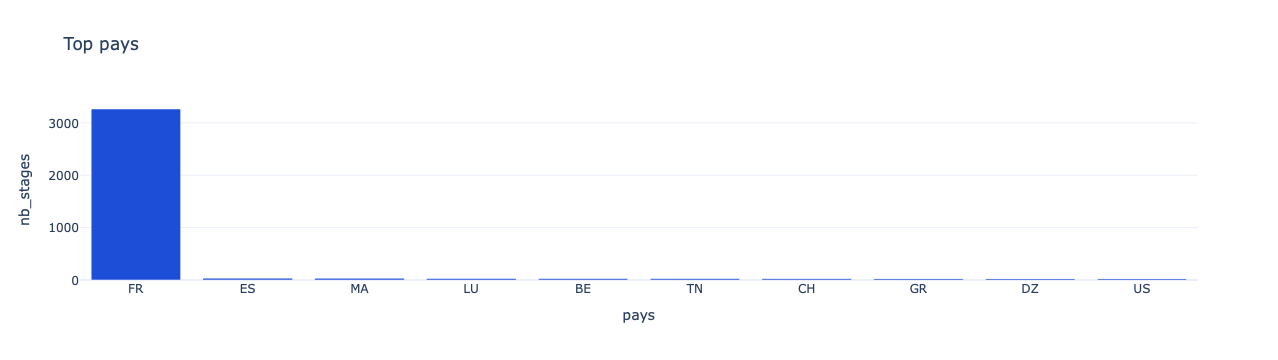

In [9]:
if "mart_geo" in tables and latest_year is not None:
    df_geo = show_df(
        "SELECT pays, nb_stages FROM mart_geo WHERE annee = ? "
        "ORDER BY nb_stages DESC LIMIT 10",
        [latest_year],
    )
elif "Pays" in cols or "pays" in cols:
    pays_col = "Pays" if "Pays" in cols else "pays"
    df_geo = show_df(
        f"SELECT {pays_col} AS pays, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_geo = None

if df_geo is None or df_geo.empty:
    fig = empty_fig("Top pays", "Aucune donnee geographique disponible.")
else:
    title = f"Top pays (annee {latest_year})" if latest_year else "Top pays"
    fig = px.bar(df_geo, x="pays", y="nb_stages", title=title)
    fig.update_layout(height=360)
fig


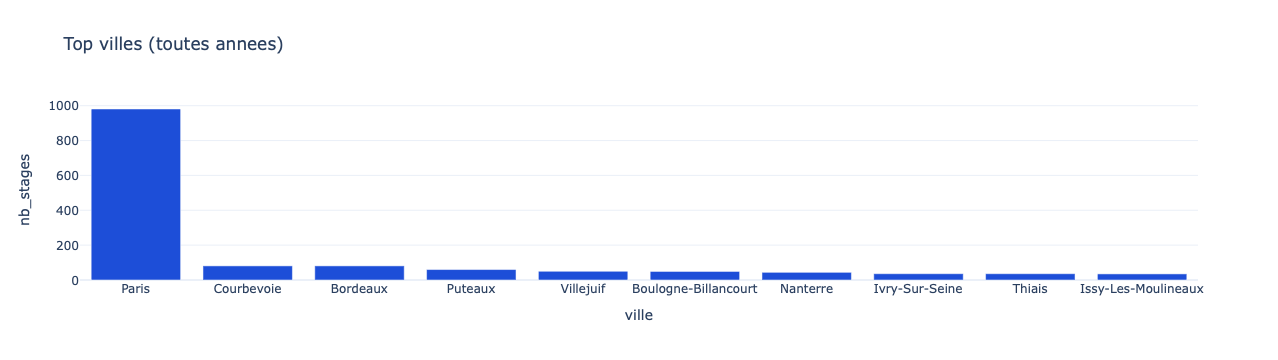

In [9]:
if "Ville" in cols:
    df_city = show_df(
        "SELECT Ville AS ville, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY ville ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_city = None

if df_city is None or df_city.empty:
    fig = empty_fig("Top villes", "Aucune donnee de ville disponible.")
else:
    fig = px.bar(df_city, x="ville", y="nb_stages",
                 title="Top villes (toutes annees)")
    fig.update_layout(height=360)
fig


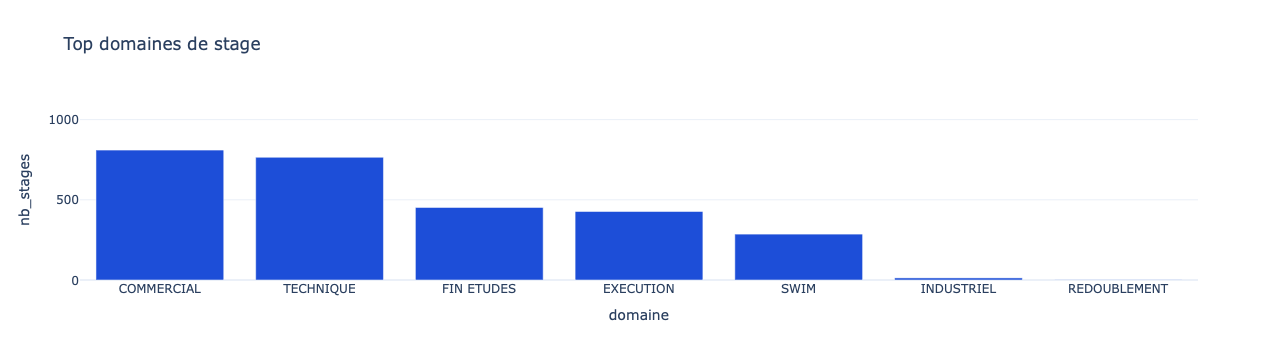

In [10]:
if "Domaine de stage" in cols:
    domain_col = "\"Domaine de stage\""
    df_domain = show_df(
        f"SELECT {domain_col} AS domaine, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_domain = None

if df_domain is None or df_domain.empty:
    fig = empty_fig("Top domaines", "Aucune donnee de domaine disponible.")
else:
    fig = px.bar(df_domain, x="domaine", y="nb_stages",
                 title="Top domaines de stage")
    fig.update_layout(height=360)
fig


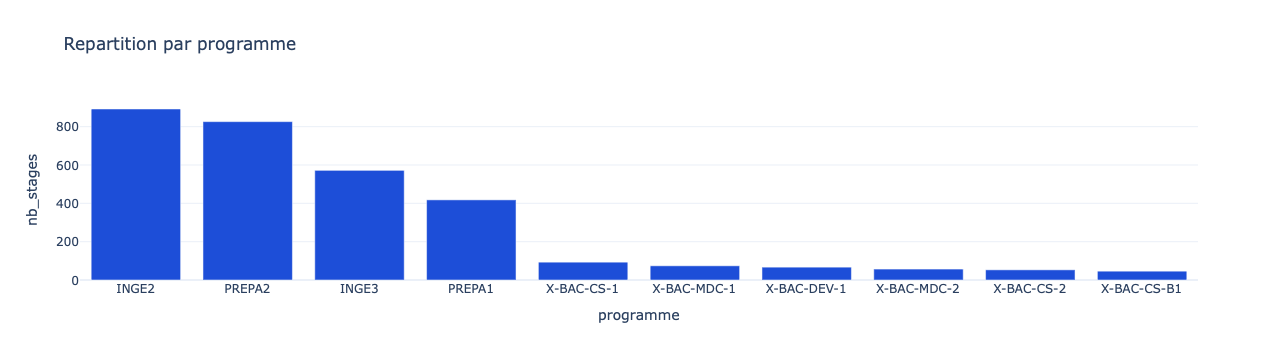

In [11]:
if "Programme" in cols:
    df_prog = show_df(
        "SELECT Programme AS programme, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_prog = None

if df_prog is None or df_prog.empty:
    fig = empty_fig("Programmes", "Aucune donnee de programme disponible.")
else:
    fig = px.bar(df_prog, x="programme", y="nb_stages",
                 title="Repartition par programme")
    fig.update_layout(height=360)
fig


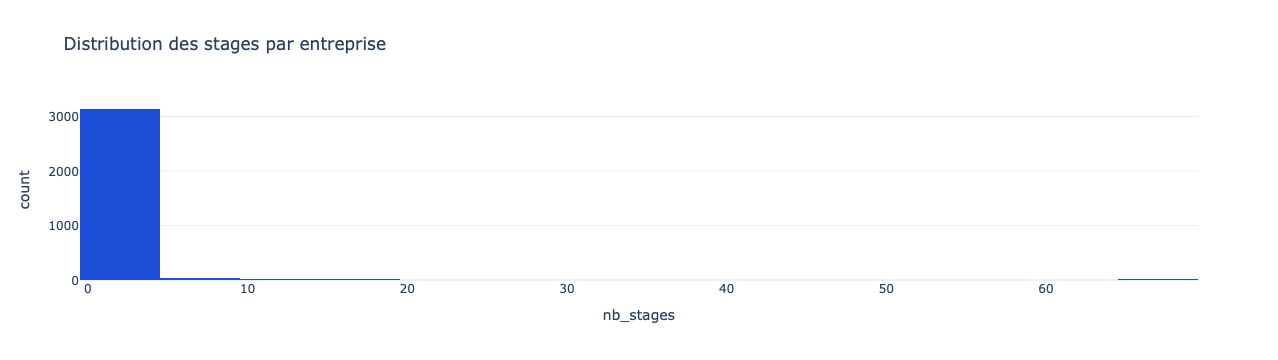

In [13]:
# Histogramme: distribution des stages par entreprise
if "Société" in cols or "Societe" in cols:
    ent_col = "\"Société\"" if "Société" in cols else "Societe"
    df_comp_hist = show_df(
        f"SELECT COUNT(*) AS nb_stages FROM stages_clean GROUP BY {ent_col}"
    )
else:
    df_comp_hist = None

if df_comp_hist is None or df_comp_hist.empty:
    fig = empty_fig("Distribution des stages par entreprise", "Aucune donnee entreprise.")
else:
    fig = px.histogram(df_comp_hist, x="nb_stages", nbins=20,
                       title="Distribution des stages par entreprise")
    fig.update_layout(height=360)
fig


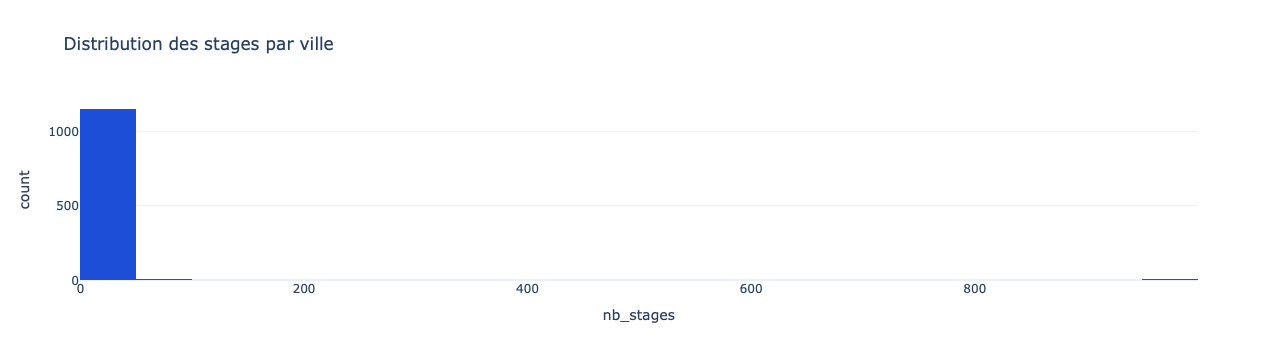

In [14]:
# Histogramme: distribution des stages par ville
if "Ville" in cols:
    df_city_hist = show_df(
        "SELECT COUNT(*) AS nb_stages FROM stages_clean GROUP BY Ville"
    )
else:
    df_city_hist = None

if df_city_hist is None or df_city_hist.empty:
    fig = empty_fig("Distribution des stages par ville", "Aucune donnee ville.")
else:
    fig = px.histogram(df_city_hist, x="nb_stages", nbins=20,
                       title="Distribution des stages par ville")
    fig.update_layout(height=360)
fig


## Requetes SQL utiles (vision globale)

Ces requetes donnent une vision d ensemble sans exposer de donnees sensibles.


In [15]:
# Colonnes disponibles
if "stages_clean" in tables:
    df_cols = con.execute("PRAGMA table_info(\"stages_clean\")").df()
    display(df_cols[["name", "type"]])
else:
    display(empty_fig("Colonnes", "Table stages_clean absente."))


,name,type
0,Programme,VARCHAR
1,Promotion,VARCHAR
2,Sujet,VARCHAR
3,Domaine de stage,VARCHAR
4,Société,VARCHAR
5,Adresse société,VARCHAR
6,Code postal,VARCHAR
7,Ville,VARCHAR
8,Pays,VARCHAR


In [16]:
# Vue d ensemble (volumes et distincts)
if "stages_clean" in tables:
    ent_col = "\"Société\"" if "Société" in cols else "Societe" if "Societe" in cols else None
    ville_col = "Ville" if "Ville" in cols else None
    pays_col = "Pays" if "Pays" in cols else "pays" if "pays" in cols else None
    parts = ["COUNT(*) AS rows"]
    if ent_col:
        parts.append(f"COUNT(DISTINCT {ent_col}) AS entreprises")
    if ville_col:
        parts.append(f"COUNT(DISTINCT {ville_col}) AS villes")
    if pays_col:
        parts.append(f"COUNT(DISTINCT {pays_col}) AS pays")
    query = "SELECT " + ", ".join(parts) + " FROM stages_clean"
    df_overview = con.execute(query).df()
    display(df_overview)
else:
    display(empty_fig("Vue d ensemble", "Table stages_clean absente."))


,rows,entreprises,villes,pays
0,3820,3166,1155,79


In [17]:
# Top villes (normalisees)
if "Ville" in cols:
    df_top_cities = show_df(
        "SELECT LOWER(TRIM(Ville)) AS ville, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 15"
    )
    display(df_top_cities)
else:
    display(empty_fig("Top villes", "Colonne Ville absente."))


,ville,nb_stages
0,paris,981
1,bordeaux,81
2,courbevoie,81
3,puteaux,60
4,villejuif,50
5,boulogne-billancourt,49
6,nanterre,44
7,thiais,36
8,ivry-sur-seine,36
9,issy-les-moulineaux,35


In [18]:
# Top domaines
if "Domaine de stage" in cols:
    domain_col = "\"Domaine de stage\""
    df_top_domains = show_df(
        f"SELECT {domain_col} AS domaine, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 15"
    )
    display(df_top_domains)
else:
    display(empty_fig("Top domaines", "Colonne Domaine de stage absente."))


,domaine,nb_stages
0,None,1066
1,COMMERCIAL,810
2,TECHNIQUE,765
3,FIN ETUDES,452
4,EXECUTION,427
5,SWIM,286
6,INDUSTRIEL,13
7,REDOUBLEMENT,1


In [19]:
# Programmes les plus representes
if "Programme" in cols:
    df_top_prog = show_df(
        "SELECT Programme AS programme, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 15"
    )
    display(df_top_prog)
else:
    display(empty_fig("Top programmes", "Colonne Programme absente."))


,programme,nb_stages
0,INGE2,892
1,PREPA2,826
2,INGE3,572
3,PREPA1,418
4,X-BAC-CS-1,93
5,X-BAC-MDC-1,74
6,X-BAC-DEV-1,67
7,X-BAC-MDC-2,57
8,X-BAC-CS-2,53
9,X-BAC-CS-B1,46


In [20]:
# Volume par annee
if YEAR_EXPR != "NULL":
    query_year = (
        f"SELECT CAST({YEAR_EXPR} AS INTEGER) AS annee, COUNT(*) AS nb_stages "
        f"FROM stages_clean WHERE {YEAR_EXPR} IS NOT NULL GROUP BY 1 ORDER BY 1"
    )
    df_year = show_df(query_year)
    display(df_year)
else:
    display(empty_fig("Volume par annee", "Annee non disponible pour le calcul."))


,annee,nb_stages
0,2023,2652
1,2024,1168



## SQL Commandes

In [21]:
# 1) Check tables + row counts
con.sql("SHOW TABLES").df()

con.sql("SELECT COUNT(*) AS rows_clean FROM stages_clean").df()

# 2) If marts exist
con.sql("SELECT COUNT(*) AS rows_mart_trends FROM mart_trends").df()
con.sql("SELECT COUNT(*) AS rows_mart_top FROM mart_top_companies").df()
con.sql("SELECT COUNT(*) AS rows_mart_geo FROM mart_geo").df()

# 3) Quick global view
con.sql("""
SELECT
  CAST(regexp_extract(CAST(Promotion AS VARCHAR), '(20\\d{2})', 1) AS INTEGER) AS annee,
  COUNT(*) AS nb_stages
FROM stages_clean
WHERE Promotion IS NOT NULL
GROUP BY 1
ORDER BY 1
""").df()

con.sql("""
SELECT "Société" AS entreprise, COUNT(*) AS nb_stages
FROM stages_clean
GROUP BY 1
ORDER BY nb_stages DESC
LIMIT 10
""").df()

con.sql("""
SELECT Ville AS ville, COUNT(*) AS nb_stages
FROM stages_clean
GROUP BY 1
ORDER BY nb_stages DESC
LIMIT 10
""").df()


,ville,nb_stages
0,Paris,981
1,Courbevoie,81
2,Bordeaux,81
3,Puteaux,60
4,Villejuif,50
5,Boulogne-Billancourt,49
6,Nanterre,44
7,Thiais,36
8,Ivry-Sur-Seine,36
9,Issy-Les-Moulineaux,35


In [22]:
df_top = con.execute("""
    SELECT "Société" AS entreprise, COUNT(*) AS nb_stages
    FROM stages_clean
    GROUP BY 1
    ORDER BY nb_stages DESC
    LIMIT 10
""").df()
df_top


,entreprise,nb_stages
0,Darty,68
1,BNP Paribas,16
2,Worldwide Friends,12
3,Société Générale,12
4,Bouygues Telecom,11
5,SOCIETE GENERALE,10
6,ALTEN SA,10
7,Wavestone SA,9
8,Orange,8
9,Hopeland Dog Sanctuary,7


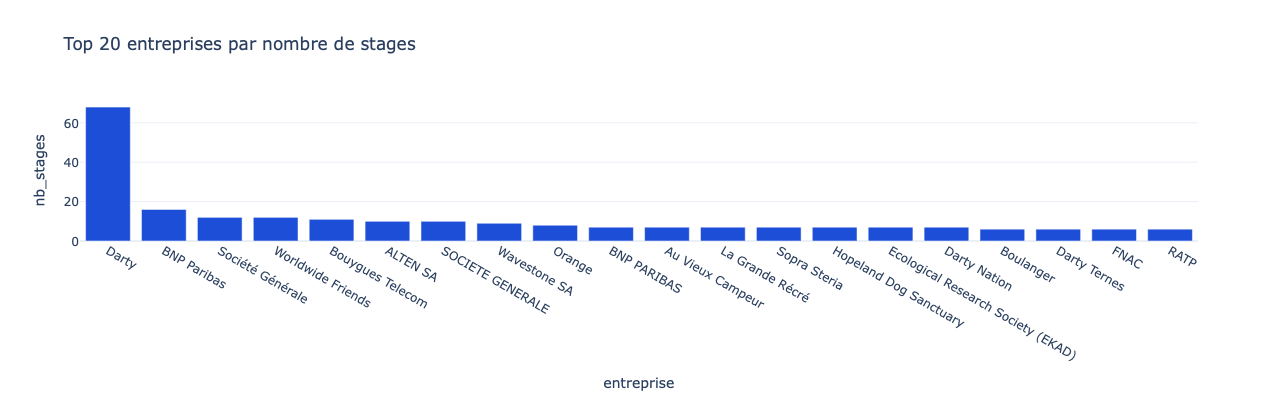

In [23]:
import plotly.express as px

df_top = con.execute("""
    SELECT "Société" AS entreprise, COUNT(*) AS nb_stages
    FROM stages_clean
    GROUP BY 1
    ORDER BY nb_stages DESC
    LIMIT 20
""").df()

fig = px.bar(
    df_top,
    x="entreprise",
    y="nb_stages",
    title="Top 20 entreprises par nombre de stages"
)
fig.update_layout(height=400)
fig


In [24]:
df_top = con.execute("""
WITH company_city AS (
    SELECT
        "Société" AS entreprise,
        Ville AS ville,
        COUNT(*) AS nb_stages_city
    FROM stages_clean
    GROUP BY 1, 2
),
company_totals AS (
    SELECT
        entreprise,
        SUM(nb_stages_city) AS nb_stages
    FROM company_city
    GROUP BY 1
),
top_city AS (
    SELECT
        entreprise,
        ville,
        nb_stages_city,
        ROW_NUMBER() OVER (PARTITION BY entreprise ORDER BY nb_stages_city DESC) AS rn
    FROM company_city
)
SELECT
    t.entreprise,
    t.nb_stages,
    c.ville AS top_ville,
    c.nb_stages_city AS nb_stages_top_ville
FROM company_totals t
LEFT JOIN top_city c
    ON t.entreprise = c.entreprise AND c.rn = 1
ORDER BY t.nb_stages DESC
LIMIT 20
""").df()

df_top


,entreprise,nb_stages,top_ville,nb_stages_top_ville
0,Darty,68.0,Paris,20
1,BNP Paribas,16.0,Paris,14
2,Société Générale,12.0,Puteaux,4
3,Worldwide Friends,12.0,Reykjavik,5
4,Bouygues Telecom,11.0,Meudon,6
5,SOCIETE GENERALE,10.0,Paris La Defense Cedex,4
6,ALTEN SA,10.0,Boulogne-Billancourt,10
7,Wavestone SA,9.0,Paris La Defense,8
8,Orange,8.0,Issy Les Moulineaux,3
9,Darty Nation,7.0,Paris,7


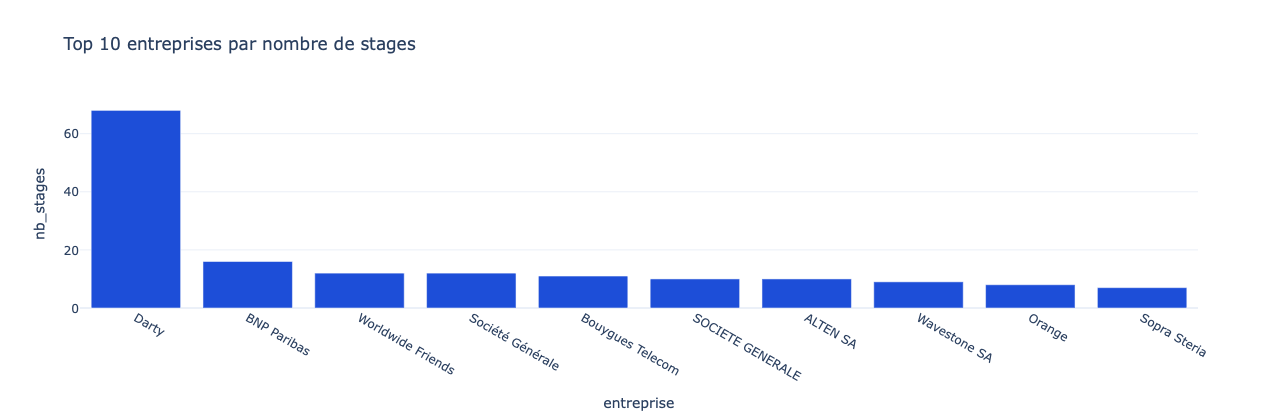

In [25]:
import plotly.express as px

df_top = con.execute("""
WITH company_city AS (
    SELECT
        "Société" AS entreprise,
        Ville AS ville,
        COUNT(*) AS nb_stages_city
    FROM stages_clean
    GROUP BY 1, 2
),
company_totals AS (
    SELECT
        entreprise,
        SUM(nb_stages_city) AS nb_stages
    FROM company_city
    GROUP BY 1
),
top_city AS (
    SELECT
        entreprise,
        ville,
        nb_stages_city,
        ROW_NUMBER() OVER (PARTITION BY entreprise ORDER BY nb_stages_city DESC) AS rn
    FROM company_city
)
SELECT
    t.entreprise,
    t.nb_stages,
    c.ville AS top_ville,
    c.nb_stages_city AS nb_stages_top_ville
FROM company_totals t
LEFT JOIN top_city c
    ON t.entreprise = c.entreprise AND c.rn = 1
ORDER BY t.nb_stages DESC
LIMIT 10
""").df()

fig = px.bar(
    df_top,
    x="entreprise",
    y="nb_stages",
    title="Top 10 entreprises par nombre de stages",
    hover_data=["top_ville", "nb_stages_top_ville"]
)
fig.update_layout(height=420)
fig


## Focus Bordeaux

Trois graphiques simples et lisibles, chacun dans sa propre cellule.


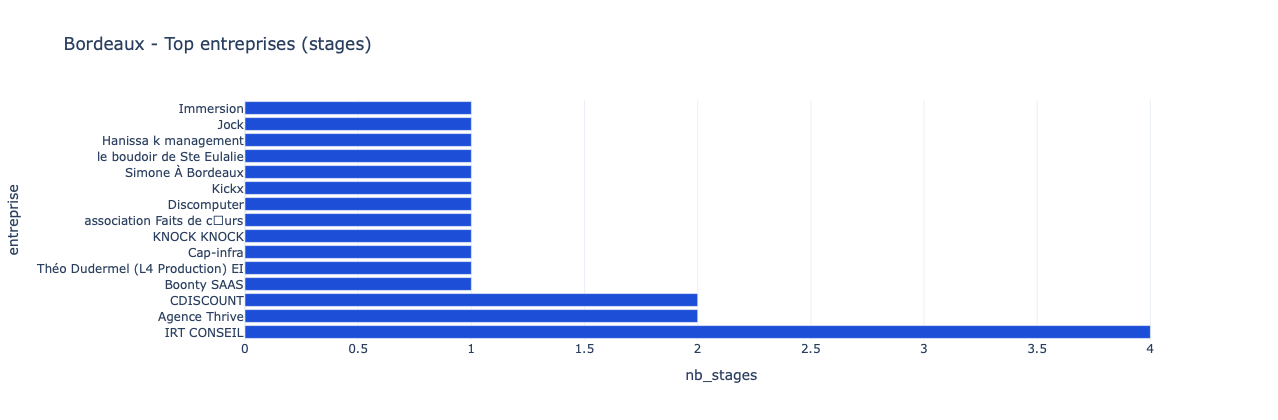

In [26]:
import plotly.express as px

px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = ["#1D4ED8"]

city_filter = "LOWER(TRIM(Ville)) = 'bordeaux'"

df_bdx_companies = con.execute(f"""
    SELECT "Société" AS entreprise, COUNT(*) AS nb_stages
    FROM stages_clean
    WHERE {city_filter}
    GROUP BY 1
    ORDER BY nb_stages DESC
    LIMIT 15
""").df()

fig = px.bar(
    df_bdx_companies,
    x="nb_stages",
    y="entreprise",
    orientation="h",
    title="Bordeaux - Top entreprises (stages)"
)
fig.update_layout(height=420)
fig


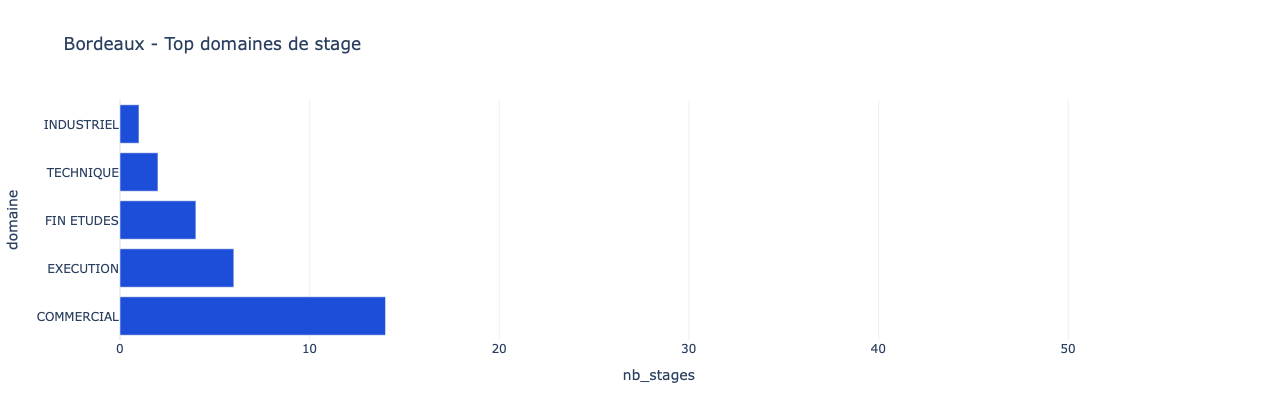

In [27]:
import plotly.express as px

px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = ["#1D4ED8"]

city_filter = "LOWER(TRIM(Ville)) = 'bordeaux'"

df_bdx_domains = con.execute(f"""
    SELECT "Domaine de stage" AS domaine, COUNT(*) AS nb_stages
    FROM stages_clean
    WHERE {city_filter}
    GROUP BY 1
    ORDER BY nb_stages DESC
    LIMIT 12
""").df()

fig = px.bar(
    df_bdx_domains,
    x="nb_stages",
    y="domaine",
    orientation="h",
    title="Bordeaux - Top domaines de stage"
)
fig.update_layout(height=420)
fig


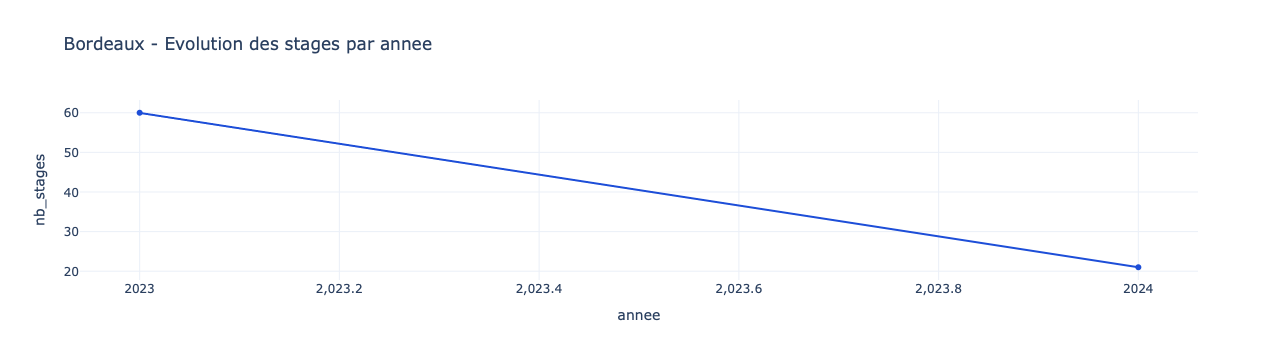

In [28]:
import plotly.express as px

px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = ["#1D4ED8"]

city_filter = "LOWER(TRIM(Ville)) = 'bordeaux'"

df_bdx_trend = con.execute(f"""
    SELECT
        CAST(regexp_extract(CAST(Promotion AS VARCHAR), '(20\\d{{2}})', 1) AS INTEGER) AS annee,
        COUNT(*) AS nb_stages
    FROM stages_clean
    WHERE {city_filter}
      AND Promotion IS NOT NULL
    GROUP BY 1
    ORDER BY 1
""").df()

fig = px.line(
    df_bdx_trend,
    x="annee",
    y="nb_stages",
    markers=True,
    title="Bordeaux - Evolution des stages par annee"
)
fig.update_layout(height=360)
fig


In [29]:
df_companies = con.execute("""
    SELECT "Société" AS entreprise, COUNT(*) AS nb_stages
    FROM stages_clean
    GROUP BY 1
    HAVING COUNT(*) > 5
    ORDER BY nb_stages DESC
""").df()

df_companies


,entreprise,nb_stages
0,Darty,68
1,BNP Paribas,16
2,Société Générale,12
3,Worldwide Friends,12
4,Bouygues Telecom,11
5,ALTEN SA,10
6,SOCIETE GENERALE,10
7,Wavestone SA,9
8,Orange,8
9,Hopeland Dog Sanctuary,7


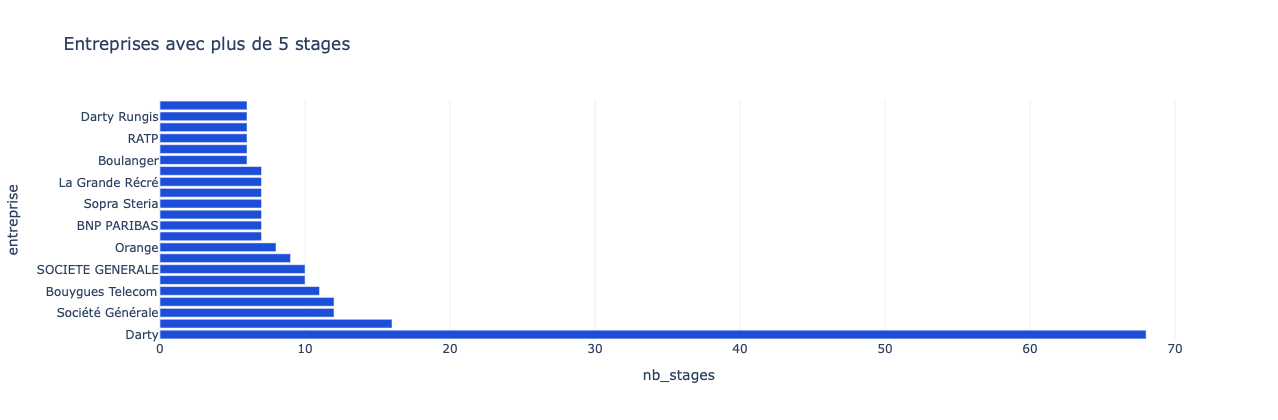

In [30]:
df_top = df_companies

fig = px.bar(
    df_top,
    x="nb_stages",
    y="entreprise",
    orientation="h",
    title="Entreprises avec plus de 5 stages",
)
fig.update_layout(height=420)
fig
